# Snake

In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

tf.random.set_seed(0)

import environments_fully_observable 
import environments_partially_observable
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import os
import random
# import tensorflow as tf
# tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)

# GPU configuration
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
TensorFlow version: 2.10.1


## Environment definition

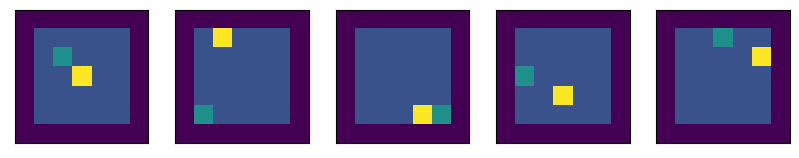

In [2]:
%matplotlib inline
# function to standardize getting an env for the whole notebook
def get_env(n=1000, partially_observable=False):
    # n is the number of boards that you want to simulate parallely
    # size is the size of each board, also considering the borders
    # mask for the partially observable, is the size of the local neighborhood
    size = 7
    if partially_observable:
        e = environments_partially_observable.OriginalSnakeEnvironment(n, size, 3)
    else:
        e = environments_fully_observable.OriginalSnakeEnvironment(n, size)
    # or environments_partially_observable.OriginalSnakeEnvironment(n, size, 2)
    return e
env_ = get_env()
GAMMA = .9
ITERATIONS = 5000

fig,axs=plt.subplots(1,min(len(env_.boards), 5), figsize=(10,3))
for ax, board in zip(axs, env_.boards):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(board, origin="lower")

## DQN Agent

In [3]:
from dqn import DQNAgent

agent = DQNAgent(state_shape=env_.to_state().shape[1:], gamma=GAMMA, n_actions=4, epsilon_start=1., epsilon_end=0.05, epsilon_decay=0.9995, learning_rate=1e-4, target_update_freq=100)

## Training

In [4]:
def training(iterations, env, agent, save_weights=True, save_path="weights/", file_name="weights.h5"):
    rewards_hist = []
    walls_hist = []
    fruit_hist = []
    loss_hist = []
    max_fruits_eaten = 0

    for iteration in trange(iterations):
        state = tf.constant(env.to_state())
        actions = agent.select_action(state)
        rewards = env.move(actions)
        new_state = tf.constant(env.to_state())
        dones = np.isin(rewards, [env_.WIN_REWARD, env_.HIT_WALL_REWARD, env_.ATE_HIMSELF_REWARD])
        loss = agent.train(state, actions, rewards, new_state, dones)
        mean_reward = tf.reduce_mean(rewards).numpy()
        rewards_hist.append(mean_reward)
        if loss is not None:
            loss_hist.append(loss)
        wall_hits_count = np.sum(rewards == env_.HIT_WALL_REWARD)
        walls_hist.append(wall_hits_count)

        fruits_eaten_count = np.sum(rewards == env_.FRUIT_REWARD)
        fruit_hist.append(fruits_eaten_count)

        if iteration % 100 == 0:
            avg_reward = np.mean(rewards_hist[-100:]) if rewards_hist else 0
            avg_loss = np.mean(loss_hist[-100:]) if loss_hist else 0

            fruits_eaten = tf.reduce_sum(tf.cast(rewards == 0.5, tf.int32)).numpy()
            max_fruits_eaten = max(max_fruits_eaten, fruits_eaten)
            print(f"Iteration {iteration}: Avg Reward: {avg_reward:.2f}, Avg Loss: {avg_loss:.4f}")
            print(f"Fruits eaten: {fruits_eaten}, Max fruits eaten: {max_fruits_eaten}")
            print(f"Wall hits: {wall_hits_count}")

    if save_weights:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        agent.save_weights(os.path.join(save_path, file_name))
        print(f"Weights saved to {os.path.join(save_path, file_name)}")

    return rewards_hist, walls_hist, fruit_hist, loss_hist

In [5]:
rewards_history = []
wall_hits = []
fruits_eaten_ = []
loss_history = []

rewards_history, wall_hits, fruits_eaten_, loss_history = training(ITERATIONS, env_, agent, save_weights=True, save_path="weights/", file_name="snake_dqn_weights.h5")

  0%|          | 1/5000 [00:01<2:03:30,  1.48s/it]

Iteration 0: Avg Reward: 0.00, Avg Loss: 0.0428
Fruits eaten: 40, Max fruits eaten: 40
Wall hits: 192


  2%|▏         | 101/5000 [01:37<1:18:15,  1.04it/s]

Iteration 100: Avg Reward: -0.01, Avg Loss: 0.0088
Fruits eaten: 11, Max fruits eaten: 40
Wall hits: 181


  4%|▍         | 201/5000 [03:12<1:16:21,  1.05it/s]

Iteration 200: Avg Reward: -0.01, Avg Loss: 0.0058
Fruits eaten: 29, Max fruits eaten: 40
Wall hits: 174


  6%|▌         | 301/5000 [04:47<1:14:10,  1.06it/s]

Iteration 300: Avg Reward: -0.01, Avg Loss: 0.0064
Fruits eaten: 12, Max fruits eaten: 40
Wall hits: 178


  8%|▊         | 401/5000 [06:28<1:29:47,  1.17s/it]

Iteration 400: Avg Reward: -0.01, Avg Loss: 0.0066
Fruits eaten: 31, Max fruits eaten: 40
Wall hits: 159


 10%|█         | 501/5000 [08:17<1:12:34,  1.03it/s]

Iteration 500: Avg Reward: -0.00, Avg Loss: 0.0077
Fruits eaten: 43, Max fruits eaten: 43
Wall hits: 0


 12%|█▏        | 601/5000 [09:58<1:09:19,  1.06it/s]

Iteration 600: Avg Reward: -0.00, Avg Loss: 0.0083
Fruits eaten: 21, Max fruits eaten: 43
Wall hits: 197


 14%|█▍        | 701/5000 [11:33<1:08:47,  1.04it/s]

Iteration 700: Avg Reward: 0.00, Avg Loss: 0.0092
Fruits eaten: 34, Max fruits eaten: 43
Wall hits: 170


 16%|█▌        | 801/5000 [13:09<1:09:02,  1.01it/s]

Iteration 800: Avg Reward: 0.00, Avg Loss: 0.0087
Fruits eaten: 194, Max fruits eaten: 194
Wall hits: 0


 18%|█▊        | 901/5000 [14:45<1:05:02,  1.05it/s]

Iteration 900: Avg Reward: 0.01, Avg Loss: 0.0114
Fruits eaten: 193, Max fruits eaten: 194
Wall hits: 3


 20%|██        | 1001/5000 [16:26<1:03:00,  1.06it/s]

Iteration 1000: Avg Reward: 0.02, Avg Loss: 0.0115
Fruits eaten: 26, Max fruits eaten: 194
Wall hits: 162


 22%|██▏       | 1101/5000 [18:02<1:01:45,  1.05it/s]

Iteration 1100: Avg Reward: 0.03, Avg Loss: 0.0140
Fruits eaten: 56, Max fruits eaten: 194
Wall hits: 150


 24%|██▍       | 1201/5000 [19:39<1:00:49,  1.04it/s]

Iteration 1200: Avg Reward: 0.03, Avg Loss: 0.0166
Fruits eaten: 113, Max fruits eaten: 194
Wall hits: 2


 26%|██▌       | 1301/5000 [21:15<58:36,  1.05it/s]  

Iteration 1300: Avg Reward: 0.04, Avg Loss: 0.0181
Fruits eaten: 71, Max fruits eaten: 194
Wall hits: 117


 28%|██▊       | 1401/5000 [22:51<56:38,  1.06it/s]  

Iteration 1400: Avg Reward: 0.04, Avg Loss: 0.0229
Fruits eaten: 165, Max fruits eaten: 194
Wall hits: 0


 30%|███       | 1501/5000 [24:26<55:58,  1.04it/s]

Iteration 1500: Avg Reward: 0.05, Avg Loss: 0.0219
Fruits eaten: 70, Max fruits eaten: 194
Wall hits: 104


 32%|███▏      | 1601/5000 [26:02<53:58,  1.05it/s]

Iteration 1600: Avg Reward: 0.05, Avg Loss: 0.0246
Fruits eaten: 285, Max fruits eaten: 285
Wall hits: 3


 34%|███▍      | 1701/5000 [27:38<53:06,  1.04it/s]

Iteration 1700: Avg Reward: 0.06, Avg Loss: 0.0235
Fruits eaten: 250, Max fruits eaten: 285
Wall hits: 3


 36%|███▌      | 1801/5000 [29:13<51:21,  1.04it/s]

Iteration 1800: Avg Reward: 0.05, Avg Loss: 0.0285
Fruits eaten: 257, Max fruits eaten: 285
Wall hits: 7


 38%|███▊      | 1901/5000 [30:50<49:21,  1.05it/s]

Iteration 1900: Avg Reward: 0.06, Avg Loss: 0.0305
Fruits eaten: 26, Max fruits eaten: 285
Wall hits: 166


 40%|████      | 2001/5000 [32:25<47:16,  1.06it/s]

Iteration 2000: Avg Reward: 0.05, Avg Loss: 0.0319
Fruits eaten: 77, Max fruits eaten: 285
Wall hits: 111


 42%|████▏     | 2101/5000 [34:01<46:52,  1.03it/s]

Iteration 2100: Avg Reward: 0.05, Avg Loss: 0.0311
Fruits eaten: 138, Max fruits eaten: 285
Wall hits: 0


 44%|████▍     | 2201/5000 [35:38<44:38,  1.05it/s]

Iteration 2200: Avg Reward: 0.06, Avg Loss: 0.0343
Fruits eaten: 66, Max fruits eaten: 285
Wall hits: 100


 46%|████▌     | 2301/5000 [37:15<43:43,  1.03it/s]

Iteration 2300: Avg Reward: 0.07, Avg Loss: 0.0286
Fruits eaten: 147, Max fruits eaten: 285
Wall hits: 11


 48%|████▊     | 2401/5000 [38:51<41:25,  1.05it/s]

Iteration 2400: Avg Reward: 0.08, Avg Loss: 0.0313
Fruits eaten: 277, Max fruits eaten: 285
Wall hits: 0


 50%|█████     | 2501/5000 [40:27<39:57,  1.04it/s]

Iteration 2500: Avg Reward: 0.07, Avg Loss: 0.0333
Fruits eaten: 328, Max fruits eaten: 328
Wall hits: 1


 52%|█████▏    | 2601/5000 [42:04<38:22,  1.04it/s]

Iteration 2600: Avg Reward: 0.07, Avg Loss: 0.0340
Fruits eaten: 75, Max fruits eaten: 328
Wall hits: 113


 54%|█████▍    | 2701/5000 [43:41<37:05,  1.03it/s]

Iteration 2700: Avg Reward: 0.09, Avg Loss: 0.0348
Fruits eaten: 138, Max fruits eaten: 328
Wall hits: 9


 56%|█████▌    | 2801/5000 [45:18<35:13,  1.04it/s]

Iteration 2800: Avg Reward: 0.07, Avg Loss: 0.0415
Fruits eaten: 40, Max fruits eaten: 328
Wall hits: 164


 58%|█████▊    | 2901/5000 [46:54<33:34,  1.04it/s]

Iteration 2900: Avg Reward: 0.08, Avg Loss: 0.0436
Fruits eaten: 304, Max fruits eaten: 328
Wall hits: 2


 60%|██████    | 3001/5000 [48:30<31:59,  1.04it/s]

Iteration 3000: Avg Reward: 0.08, Avg Loss: 0.0413
Fruits eaten: 63, Max fruits eaten: 328
Wall hits: 143


 62%|██████▏   | 3101/5000 [50:07<30:48,  1.03it/s]

Iteration 3100: Avg Reward: 0.09, Avg Loss: 0.0334
Fruits eaten: 271, Max fruits eaten: 328
Wall hits: 11


 64%|██████▍   | 3201/5000 [51:43<28:41,  1.05it/s]

Iteration 3200: Avg Reward: 0.08, Avg Loss: 0.0386
Fruits eaten: 218, Max fruits eaten: 328
Wall hits: 0


 66%|██████▌   | 3301/5000 [53:19<27:06,  1.04it/s]

Iteration 3300: Avg Reward: 0.09, Avg Loss: 0.0357
Fruits eaten: 264, Max fruits eaten: 328
Wall hits: 9


 68%|██████▊   | 3401/5000 [54:56<25:49,  1.03it/s]

Iteration 3400: Avg Reward: 0.10, Avg Loss: 0.0358
Fruits eaten: 257, Max fruits eaten: 328
Wall hits: 8


 70%|███████   | 3501/5000 [56:33<24:16,  1.03it/s]

Iteration 3500: Avg Reward: 0.09, Avg Loss: 0.0428
Fruits eaten: 257, Max fruits eaten: 328
Wall hits: 8


 72%|███████▏  | 3601/5000 [58:10<22:15,  1.05it/s]

Iteration 3600: Avg Reward: 0.10, Avg Loss: 0.0427
Fruits eaten: 317, Max fruits eaten: 328
Wall hits: 1


 74%|███████▍  | 3701/5000 [59:46<20:59,  1.03it/s]

Iteration 3700: Avg Reward: 0.09, Avg Loss: 0.0490
Fruits eaten: 80, Max fruits eaten: 328
Wall hits: 132


 76%|███████▌  | 3801/5000 [1:01:26<21:51,  1.09s/it]

Iteration 3800: Avg Reward: 0.10, Avg Loss: 0.0501
Fruits eaten: 256, Max fruits eaten: 328
Wall hits: 0


 78%|███████▊  | 3901/5000 [1:03:06<17:51,  1.03it/s]

Iteration 3900: Avg Reward: 0.10, Avg Loss: 0.0416
Fruits eaten: 246, Max fruits eaten: 328
Wall hits: 4


 80%|████████  | 4001/5000 [1:04:45<16:15,  1.02it/s]

Iteration 4000: Avg Reward: 0.10, Avg Loss: 0.0408
Fruits eaten: 293, Max fruits eaten: 328
Wall hits: 2


 82%|████████▏ | 4101/5000 [1:06:23<14:41,  1.02it/s]

Iteration 4100: Avg Reward: 0.09, Avg Loss: 0.0441
Fruits eaten: 283, Max fruits eaten: 328
Wall hits: 1


 84%|████████▍ | 4201/5000 [1:08:02<12:59,  1.02it/s]

Iteration 4200: Avg Reward: 0.11, Avg Loss: 0.0337
Fruits eaten: 65, Max fruits eaten: 328
Wall hits: 141


 86%|████████▌ | 4301/5000 [1:09:39<11:20,  1.03it/s]

Iteration 4300: Avg Reward: 0.10, Avg Loss: 0.0417
Fruits eaten: 69, Max fruits eaten: 328
Wall hits: 127


 88%|████████▊ | 4401/5000 [1:11:17<09:49,  1.02it/s]

Iteration 4400: Avg Reward: 0.11, Avg Loss: 0.0414
Fruits eaten: 281, Max fruits eaten: 328
Wall hits: 4


 90%|█████████ | 4501/5000 [1:12:56<08:06,  1.03it/s]

Iteration 4500: Avg Reward: 0.11, Avg Loss: 0.0417
Fruits eaten: 281, Max fruits eaten: 328
Wall hits: 0


 92%|█████████▏| 4601/5000 [1:14:35<06:30,  1.02it/s]

Iteration 4600: Avg Reward: 0.11, Avg Loss: 0.0396
Fruits eaten: 249, Max fruits eaten: 328
Wall hits: 2


 94%|█████████▍| 4701/5000 [1:16:15<04:52,  1.02it/s]

Iteration 4700: Avg Reward: 0.11, Avg Loss: 0.0399
Fruits eaten: 283, Max fruits eaten: 328
Wall hits: 3


 96%|█████████▌| 4801/5000 [1:17:53<03:16,  1.01it/s]

Iteration 4800: Avg Reward: 0.11, Avg Loss: 0.0457
Fruits eaten: 269, Max fruits eaten: 328
Wall hits: 3


 98%|█████████▊| 4901/5000 [1:19:31<01:38,  1.01it/s]

Iteration 4900: Avg Reward: 0.12, Avg Loss: 0.0352
Fruits eaten: 285, Max fruits eaten: 328
Wall hits: 3


100%|██████████| 5000/5000 [1:21:09<00:00,  1.03it/s]

Model weights saved to weights/snake_dqn_weights.h5
Weights saved to weights/snake_dqn_weights.h5


### Load the weights - DQN Agent

In [ ]:
env = get_env()
agent = DQNAgent(state_shape=env.to_state().shape[1:], gamma=GAMMA, n_actions=4, epsilon_start=1., epsilon_end=0.05, epsilon_decay=0.9995, learning_rate=1e-4, target_update_freq=100)

agent.load_weights("weights/snake_dqn_weights.h5")
agent.epsilon = agent.epsilon_end

rewards_history_loaded = []
wall_hits_loaded = []
fruits_eaten_loaded = []

for iteration in trange(ITERATIONS):
    state = tf.constant(env.to_state())
    actions = agent.select_action(state)
    rewards = env.move(actions)
    wall_hits_count = np.sum(rewards == env.HIT_WALL_REWARD)
    wall_hits_loaded.append(wall_hits_count)
    fruits_eaten_count = np.sum(rewards == env.FRUIT_REWARD)
    fruits_eaten_loaded.append(fruits_eaten_count)
    rewards_history_loaded.append(np.mean(rewards))
    dones = np.isin(rewards.numpy().flatten(), [env.WIN_REWARD, env.HIT_WALL_REWARD, env.ATE_HIMSELF_REWARD])

print(f"Avg Reward: {np.mean(rewards_history_loaded):.2f}")
print(f"Avg Wall Hits: {np.mean(wall_hits_loaded):.2f}")
print(f"Avg Fruits Eaten: {np.mean(fruits_eaten_loaded):.2f}")

Model weights loaded from snake_dqn_weights.h5


100%|██████████| 5000/5000 [02:26<00:00, 34.09it/s]

Avg Reward: 0.12
Avg Wall Hits: 9.71
Avg Fruits Eaten: 263.35


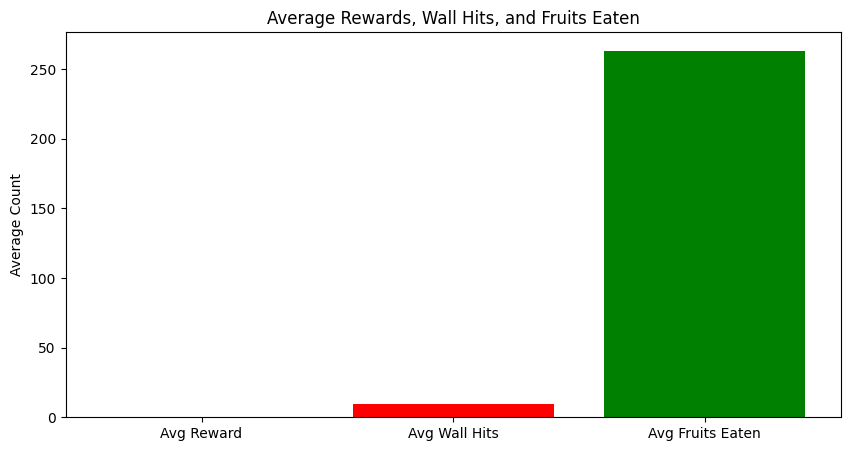

In [32]:
# Plot a bar chart of the average rewards, wall hits, and fruits eaten
plt.figure(figsize=(10, 5))
plt.bar(['Avg Reward', 'Avg Wall Hits', 'Avg Fruits Eaten'], [np.mean(rewards_history_loaded), np.mean(wall_hits_loaded), np.mean(fruits_eaten_loaded)], color=['blue', 'red', 'green'])
plt.ylabel('Average Count')
plt.title('Average Rewards, Wall Hits, and Fruits Eaten')
plt.show()


### Load the weights - Testing on Partially Observable Environment

In [ ]:
env = get_env(partially_observable=True)
agent = DQNAgent(state_shape=env.to_state().shape[1:], gamma=GAMMA, n_actions=4, epsilon_start=1., epsilon_end=0.05, epsilon_decay=0.9995, learning_rate=1e-4, target_update_freq=100)

agent.load_weights("weights/snake_dqn_weights.h5")
agent.epsilon = agent.epsilon_end

rewards_history_loaded_po = []
wall_hits_loaded_po = []
fruits_eaten_loaded_po = []

for iteration in trange(ITERATIONS):
    state = tf.constant(env.to_state())
    actions = agent.select_action(state)
    rewards = env.move(actions)
    wall_hits_count = np.sum(rewards == env.HIT_WALL_REWARD)
    wall_hits_loaded_po.append(wall_hits_count)
    fruits_eaten_count = np.sum(rewards == env.FRUIT_REWARD)
    fruits_eaten_loaded_po.append(fruits_eaten_count)
    rewards_history_loaded_po.append(np.mean(rewards))
    dones = np.isin(rewards.numpy().flatten(), [env.WIN_REWARD, env.HIT_WALL_REWARD, env.ATE_HIMSELF_REWARD])

print(f"Avg Reward: {np.mean(rewards_history_loaded_po):.2f}")
print(f"Avg Wall Hits: {np.mean(wall_hits_loaded_po):.2f}")
print(f"Avg Fruits Eaten: {np.mean(fruits_eaten_loaded_po):.2f}")

Model weights loaded from snake_dqn_weights.h5


100%|██████████| 5000/5000 [01:23<00:00, 59.63it/s]

Avg Reward: -0.09
Avg Wall Hits: 931.52
Avg Fruits Eaten: 3.33


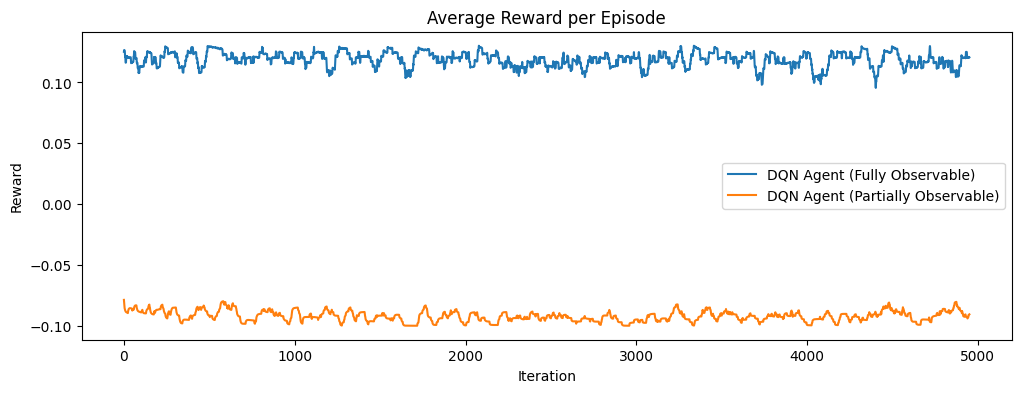

In [8]:
window = 50  # Adjust window size for more/less smoothing

def moving_average(data, window):
    return np.convolve(data, np.ones(window)/window, mode='valid')

plt.figure(figsize=(12, 4))

plt.plot(moving_average(rewards_history_loaded, window), label='DQN Agent (Fully Observable)')
plt.plot(moving_average(rewards_history_loaded_po, window), label='DQN Agent (Partially Observable)')
# plt.plot(moving_average(random_rewards, window), label='Random Agent')
# plt.plot(moving_average(heuristic_rewards, window), label='Heuristic Agent')
plt.title('Average Reward per Episode')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.legend()
plt.savefig("plots/rewards.png", bbox_inches='tight')
plt.show()
plt.close()

## A2C Agent

### Training

In [9]:
from a2c import A2CAgent

rewards_history_ac = []
wall_hits_ac = []
fruits_eaten_ac = []
loss_history_ac = []

env_ = get_env()

agent = A2CAgent(state_shape=env_.to_state().shape[1:], n_actions=4, gamma=GAMMA, learning_rate=5e-5, entropy_beta=0.0001)

rewards_history_ac, wall_hits_ac, fruits_eaten_ac, loss_history_ac = training(ITERATIONS, env_, agent, save_weights=True, save_path="weights/", file_name="snake_a2c_weights.h5")

  0%|          | 4/5000 [00:00<07:53, 10.56it/s]

Iteration 0: Avg Reward: -0.01, Avg Loss: 0.0126
Fruits eaten: 31, Max fruits eaten: 31
Wall hits: 219


  2%|▏         | 105/5000 [00:03<02:34, 31.78it/s]

Iteration 100: Avg Reward: -0.01, Avg Loss: 0.0064
Fruits eaten: 22, Max fruits eaten: 31
Wall hits: 206


  4%|▍         | 205/5000 [00:07<02:53, 27.59it/s]

Iteration 200: Avg Reward: -0.01, Avg Loss: 0.0014
Fruits eaten: 15, Max fruits eaten: 31
Wall hits: 184


  6%|▌         | 306/5000 [00:10<02:28, 31.67it/s]

Iteration 300: Avg Reward: -0.01, Avg Loss: -0.0041
Fruits eaten: 23, Max fruits eaten: 31
Wall hits: 182


  8%|▊         | 407/5000 [00:13<02:32, 30.04it/s]

Iteration 400: Avg Reward: -0.01, Avg Loss: -0.0108
Fruits eaten: 19, Max fruits eaten: 31
Wall hits: 210


 10%|█         | 505/5000 [00:17<03:04, 24.30it/s]

Iteration 500: Avg Reward: -0.01, Avg Loss: -0.0195
Fruits eaten: 30, Max fruits eaten: 31
Wall hits: 220


 12%|█▏        | 603/5000 [00:20<02:25, 30.21it/s]

Iteration 600: Avg Reward: -0.01, Avg Loss: -0.0227
Fruits eaten: 16, Max fruits eaten: 31
Wall hits: 121


 14%|█▍        | 705/5000 [00:24<02:46, 25.79it/s]

Iteration 700: Avg Reward: -0.01, Avg Loss: -0.0332
Fruits eaten: 29, Max fruits eaten: 31
Wall hits: 104


 16%|█▌        | 805/5000 [00:27<02:21, 29.55it/s]

Iteration 800: Avg Reward: -0.00, Avg Loss: -0.0404
Fruits eaten: 22, Max fruits eaten: 31
Wall hits: 67


 18%|█▊        | 903/5000 [00:31<02:20, 29.13it/s]

Iteration 900: Avg Reward: -0.00, Avg Loss: -0.0412
Fruits eaten: 21, Max fruits eaten: 31
Wall hits: 100


 20%|██        | 1007/5000 [00:34<02:14, 29.75it/s]

Iteration 1000: Avg Reward: -0.00, Avg Loss: -0.0402
Fruits eaten: 25, Max fruits eaten: 31
Wall hits: 33


 22%|██▏       | 1105/5000 [00:38<02:07, 30.60it/s]

Iteration 1100: Avg Reward: 0.00, Avg Loss: -0.0394
Fruits eaten: 17, Max fruits eaten: 31
Wall hits: 24


 24%|██▍       | 1206/5000 [00:41<02:12, 28.58it/s]

Iteration 1200: Avg Reward: 0.00, Avg Loss: -0.0410
Fruits eaten: 32, Max fruits eaten: 32
Wall hits: 19


 26%|██▌       | 1304/5000 [00:45<02:01, 30.42it/s]

Iteration 1300: Avg Reward: 0.01, Avg Loss: -0.0359
Fruits eaten: 18, Max fruits eaten: 32
Wall hits: 4


 28%|██▊       | 1406/5000 [00:48<02:01, 29.53it/s]

Iteration 1400: Avg Reward: 0.01, Avg Loss: -0.0403
Fruits eaten: 46, Max fruits eaten: 46
Wall hits: 18


 30%|███       | 1503/5000 [00:52<02:01, 28.75it/s]

Iteration 1500: Avg Reward: 0.01, Avg Loss: -0.0483
Fruits eaten: 39, Max fruits eaten: 46
Wall hits: 13


 32%|███▏      | 1605/5000 [00:55<02:19, 24.35it/s]

Iteration 1600: Avg Reward: 0.02, Avg Loss: -0.0584
Fruits eaten: 59, Max fruits eaten: 59
Wall hits: 14


 34%|███▍      | 1706/5000 [00:59<01:59, 27.59it/s]

Iteration 1700: Avg Reward: 0.02, Avg Loss: -0.0497
Fruits eaten: 42, Max fruits eaten: 59
Wall hits: 19


 36%|███▌      | 1803/5000 [01:03<02:04, 25.74it/s]

Iteration 1800: Avg Reward: 0.02, Avg Loss: -0.0449
Fruits eaten: 62, Max fruits eaten: 62
Wall hits: 18


 38%|███▊      | 1905/5000 [01:07<02:01, 25.40it/s]

Iteration 1900: Avg Reward: 0.02, Avg Loss: -0.0487
Fruits eaten: 48, Max fruits eaten: 62
Wall hits: 14


 40%|████      | 2004/5000 [01:10<02:08, 23.26it/s]

Iteration 2000: Avg Reward: 0.02, Avg Loss: -0.0498
Fruits eaten: 57, Max fruits eaten: 62
Wall hits: 10


 42%|████▏     | 2105/5000 [01:15<02:03, 23.48it/s]

Iteration 2100: Avg Reward: 0.02, Avg Loss: -0.0460
Fruits eaten: 60, Max fruits eaten: 62
Wall hits: 13


 44%|████▍     | 2204/5000 [01:18<01:58, 23.52it/s]

Iteration 2200: Avg Reward: 0.03, Avg Loss: -0.0420
Fruits eaten: 61, Max fruits eaten: 62
Wall hits: 7


 46%|████▌     | 2303/5000 [01:22<01:55, 23.33it/s]

Iteration 2300: Avg Reward: 0.03, Avg Loss: -0.0414
Fruits eaten: 64, Max fruits eaten: 64
Wall hits: 12


 48%|████▊     | 2405/5000 [01:26<01:37, 26.57it/s]

Iteration 2400: Avg Reward: 0.03, Avg Loss: -0.0404
Fruits eaten: 63, Max fruits eaten: 64
Wall hits: 10


 50%|█████     | 2505/5000 [01:31<01:43, 24.21it/s]

Iteration 2500: Avg Reward: 0.03, Avg Loss: -0.0310
Fruits eaten: 70, Max fruits eaten: 70
Wall hits: 9


 52%|█████▏    | 2604/5000 [01:35<01:43, 23.23it/s]

Iteration 2600: Avg Reward: 0.03, Avg Loss: -0.0331
Fruits eaten: 80, Max fruits eaten: 80
Wall hits: 5


 54%|█████▍    | 2703/5000 [01:39<01:39, 23.14it/s]

Iteration 2700: Avg Reward: 0.03, Avg Loss: -0.0274
Fruits eaten: 79, Max fruits eaten: 80
Wall hits: 6


 56%|█████▌    | 2805/5000 [01:43<01:21, 27.09it/s]

Iteration 2800: Avg Reward: 0.04, Avg Loss: -0.0251
Fruits eaten: 73, Max fruits eaten: 80
Wall hits: 8


 58%|█████▊    | 2904/5000 [01:47<01:31, 22.93it/s]

Iteration 2900: Avg Reward: 0.04, Avg Loss: -0.0214
Fruits eaten: 91, Max fruits eaten: 91
Wall hits: 0


 60%|██████    | 3003/5000 [01:51<01:30, 22.15it/s]

Iteration 3000: Avg Reward: 0.04, Avg Loss: -0.0227
Fruits eaten: 76, Max fruits eaten: 91
Wall hits: 4


 62%|██████▏   | 3105/5000 [01:56<01:17, 24.47it/s]

Iteration 3100: Avg Reward: 0.04, Avg Loss: -0.0184
Fruits eaten: 105, Max fruits eaten: 105
Wall hits: 3


 64%|██████▍   | 3204/5000 [02:00<01:21, 22.08it/s]

Iteration 3200: Avg Reward: 0.04, Avg Loss: -0.0076
Fruits eaten: 110, Max fruits eaten: 110
Wall hits: 7


 66%|██████▌   | 3306/5000 [02:04<01:07, 24.97it/s]

Iteration 3300: Avg Reward: 0.05, Avg Loss: -0.0193
Fruits eaten: 91, Max fruits eaten: 110
Wall hits: 5


 68%|██████▊   | 3405/5000 [02:09<01:12, 22.13it/s]

Iteration 3400: Avg Reward: 0.05, Avg Loss: -0.0046
Fruits eaten: 121, Max fruits eaten: 121
Wall hits: 4


 70%|███████   | 3504/5000 [02:13<00:57, 26.03it/s]

Iteration 3500: Avg Reward: 0.05, Avg Loss: -0.0068
Fruits eaten: 101, Max fruits eaten: 121
Wall hits: 4


 72%|███████▏  | 3603/5000 [02:17<01:05, 21.34it/s]

Iteration 3600: Avg Reward: 0.05, Avg Loss: -0.0032
Fruits eaten: 127, Max fruits eaten: 127
Wall hits: 7


 74%|███████▍  | 3705/5000 [02:21<00:52, 24.57it/s]

Iteration 3700: Avg Reward: 0.05, Avg Loss: -0.0022
Fruits eaten: 102, Max fruits eaten: 127
Wall hits: 3


 76%|███████▌  | 3804/5000 [02:26<00:54, 21.76it/s]

Iteration 3800: Avg Reward: 0.05, Avg Loss: 0.0061
Fruits eaten: 117, Max fruits eaten: 127
Wall hits: 2


 78%|███████▊  | 3903/5000 [02:30<00:49, 22.31it/s]

Iteration 3900: Avg Reward: 0.05, Avg Loss: 0.0012
Fruits eaten: 124, Max fruits eaten: 127
Wall hits: 3


 80%|████████  | 4005/5000 [02:35<00:39, 25.22it/s]

Iteration 4000: Avg Reward: 0.05, Avg Loss: 0.0099
Fruits eaten: 120, Max fruits eaten: 127
Wall hits: 2


 82%|████████▏ | 4104/5000 [02:39<00:44, 20.22it/s]

Iteration 4100: Avg Reward: 0.06, Avg Loss: 0.0065
Fruits eaten: 112, Max fruits eaten: 127
Wall hits: 1


 84%|████████▍ | 4203/5000 [02:44<00:37, 21.44it/s]

Iteration 4200: Avg Reward: 0.06, Avg Loss: 0.0137
Fruits eaten: 122, Max fruits eaten: 127
Wall hits: 0


 86%|████████▌ | 4305/5000 [02:48<00:32, 21.44it/s]

Iteration 4300: Avg Reward: 0.06, Avg Loss: 0.0119
Fruits eaten: 136, Max fruits eaten: 136
Wall hits: 1


 88%|████████▊ | 4404/5000 [02:53<00:29, 20.53it/s]

Iteration 4400: Avg Reward: 0.06, Avg Loss: 0.0129
Fruits eaten: 131, Max fruits eaten: 136
Wall hits: 0


 90%|█████████ | 4503/5000 [02:57<00:24, 20.39it/s]

Iteration 4500: Avg Reward: 0.06, Avg Loss: 0.0120
Fruits eaten: 123, Max fruits eaten: 136
Wall hits: 2


 92%|█████████▏| 4605/5000 [03:02<00:18, 21.93it/s]

Iteration 4600: Avg Reward: 0.06, Avg Loss: 0.0139
Fruits eaten: 142, Max fruits eaten: 142
Wall hits: 0


 94%|█████████▍| 4704/5000 [03:07<00:13, 21.73it/s]

Iteration 4700: Avg Reward: 0.06, Avg Loss: 0.0143
Fruits eaten: 131, Max fruits eaten: 142
Wall hits: 1


 96%|█████████▌| 4803/5000 [03:11<00:07, 24.97it/s]

Iteration 4800: Avg Reward: 0.06, Avg Loss: 0.0212
Fruits eaten: 132, Max fruits eaten: 142
Wall hits: 1


 98%|█████████▊| 4905/5000 [03:15<00:04, 22.12it/s]

Iteration 4900: Avg Reward: 0.06, Avg Loss: 0.0235
Fruits eaten: 125, Max fruits eaten: 142
Wall hits: 1


100%|██████████| 5000/5000 [03:20<00:00, 24.96it/s]

Model weights saved to weights/snake_a2c_weights.h5
Weights saved to weights/snake_a2c_weights.h5


## Double DQN

### Training

In [10]:
from ddqn import DoubleDQNAgent

rewards_history_ddqn = []
wall_hits_ddqn = []
fruits_eaten_ddqn = []
loss_history_ddqn = []

env_ = get_env()

agent = DoubleDQNAgent(state_shape=env_.to_state().shape[1:], n_actions=4, buffer_size=10000, batch_size=128, epsilon_start=1., epsilon_end=0.1, epsilon_decay=0.9995, learning_rate=1e-4, gamma=GAMMA, target_update_freq=100)
rewards_history_ddqn, wall_hits_ddqn, fruits_eaten_ddqn, loss_history_ddqn = training(ITERATIONS, env_, agent, save_weights=True, save_path="weights/", file_name="snake_ddqn_weights.h5")

  0%|          | 1/5000 [00:01<1:53:19,  1.36s/it]

Iteration 0: Avg Reward: -0.00, Avg Loss: 0.0230
Fruits eaten: 36, Max fruits eaten: 36
Wall hits: 192


  2%|▏         | 101/5000 [01:43<1:17:04,  1.06it/s]

Iteration 100: Avg Reward: -0.01, Avg Loss: 0.0109
Fruits eaten: 9, Max fruits eaten: 36
Wall hits: 201


  4%|▍         | 201/5000 [03:20<1:18:42,  1.02it/s]

Iteration 200: Avg Reward: -0.01, Avg Loss: 0.0071
Fruits eaten: 30, Max fruits eaten: 36
Wall hits: 1


  6%|▌         | 301/5000 [05:04<1:14:57,  1.04it/s]

Iteration 300: Avg Reward: -0.01, Avg Loss: 0.0065
Fruits eaten: 42, Max fruits eaten: 42
Wall hits: 2


  8%|▊         | 401/5000 [06:44<1:23:45,  1.09s/it]

Iteration 400: Avg Reward: -0.01, Avg Loss: 0.0068
Fruits eaten: 44, Max fruits eaten: 44
Wall hits: 2


 10%|█         | 501/5000 [08:31<1:18:35,  1.05s/it]

Iteration 500: Avg Reward: -0.01, Avg Loss: 0.0065
Fruits eaten: 17, Max fruits eaten: 44
Wall hits: 188


 12%|█▏        | 601/5000 [10:22<1:19:01,  1.08s/it]

Iteration 600: Avg Reward: -0.00, Avg Loss: 0.0079
Fruits eaten: 17, Max fruits eaten: 44
Wall hits: 205


 14%|█▍        | 701/5000 [12:13<1:14:39,  1.04s/it]

Iteration 700: Avg Reward: -0.00, Avg Loss: 0.0081
Fruits eaten: 21, Max fruits eaten: 44
Wall hits: 185


 16%|█▌        | 801/5000 [13:55<1:13:07,  1.04s/it]

Iteration 800: Avg Reward: 0.00, Avg Loss: 0.0096
Fruits eaten: 49, Max fruits eaten: 49
Wall hits: 149


 18%|█▊        | 901/5000 [15:40<1:05:34,  1.04it/s]

Iteration 900: Avg Reward: -0.00, Avg Loss: 0.0093
Fruits eaten: 20, Max fruits eaten: 49
Wall hits: 193


 20%|██        | 1001/5000 [17:21<1:02:34,  1.06it/s]

Iteration 1000: Avg Reward: 0.01, Avg Loss: 0.0106
Fruits eaten: 113, Max fruits eaten: 113
Wall hits: 2


 22%|██▏       | 1101/5000 [18:54<1:01:29,  1.06it/s]

Iteration 1100: Avg Reward: 0.02, Avg Loss: 0.0136
Fruits eaten: 110, Max fruits eaten: 113
Wall hits: 2


 24%|██▍       | 1201/5000 [20:30<1:03:11,  1.00it/s]

Iteration 1200: Avg Reward: 0.02, Avg Loss: 0.0145
Fruits eaten: 24, Max fruits eaten: 113
Wall hits: 176


 26%|██▌       | 1301/5000 [22:12<58:28,  1.05it/s]  

Iteration 1300: Avg Reward: 0.04, Avg Loss: 0.0150
Fruits eaten: 89, Max fruits eaten: 113
Wall hits: 2


 28%|██▊       | 1401/5000 [23:59<1:02:48,  1.05s/it]

Iteration 1400: Avg Reward: 0.04, Avg Loss: 0.0190
Fruits eaten: 31, Max fruits eaten: 113
Wall hits: 158


 30%|███       | 1501/5000 [25:42<59:53,  1.03s/it]  

Iteration 1500: Avg Reward: 0.04, Avg Loss: 0.0212
Fruits eaten: 118, Max fruits eaten: 118
Wall hits: 6


 32%|███▏      | 1601/5000 [27:28<53:18,  1.06it/s]  

Iteration 1600: Avg Reward: 0.04, Avg Loss: 0.0231
Fruits eaten: 32, Max fruits eaten: 118
Wall hits: 146


 34%|███▍      | 1701/5000 [29:05<1:07:29,  1.23s/it]

Iteration 1700: Avg Reward: 0.04, Avg Loss: 0.0243
Fruits eaten: 137, Max fruits eaten: 137
Wall hits: 3


 36%|███▌      | 1801/5000 [30:48<52:45,  1.01it/s]  

Iteration 1800: Avg Reward: 0.05, Avg Loss: 0.0269
Fruits eaten: 28, Max fruits eaten: 137
Wall hits: 150


 38%|███▊      | 1901/5000 [32:28<57:51,  1.12s/it]

Iteration 1900: Avg Reward: 0.05, Avg Loss: 0.0292
Fruits eaten: 233, Max fruits eaten: 233
Wall hits: 1


 40%|████      | 2001/5000 [34:13<53:56,  1.08s/it]  

Iteration 2000: Avg Reward: 0.06, Avg Loss: 0.0282
Fruits eaten: 66, Max fruits eaten: 233
Wall hits: 121


 42%|████▏     | 2101/5000 [36:00<54:51,  1.14s/it]

Iteration 2100: Avg Reward: 0.07, Avg Loss: 0.0299
Fruits eaten: 285, Max fruits eaten: 285
Wall hits: 4


 44%|████▍     | 2201/5000 [37:45<47:28,  1.02s/it]

Iteration 2200: Avg Reward: 0.06, Avg Loss: 0.0343
Fruits eaten: 96, Max fruits eaten: 285
Wall hits: 115


 46%|████▌     | 2301/5000 [39:29<47:29,  1.06s/it]

Iteration 2300: Avg Reward: 0.07, Avg Loss: 0.0330
Fruits eaten: 256, Max fruits eaten: 285
Wall hits: 10


 48%|████▊     | 2401/5000 [41:17<44:17,  1.02s/it]

Iteration 2400: Avg Reward: 0.06, Avg Loss: 0.0347
Fruits eaten: 75, Max fruits eaten: 285
Wall hits: 137


 50%|█████     | 2501/5000 [43:02<40:33,  1.03it/s]

Iteration 2500: Avg Reward: 0.07, Avg Loss: 0.0381
Fruits eaten: 240, Max fruits eaten: 285
Wall hits: 1


 52%|█████▏    | 2601/5000 [44:41<39:10,  1.02it/s]

Iteration 2600: Avg Reward: 0.08, Avg Loss: 0.0376
Fruits eaten: 65, Max fruits eaten: 285
Wall hits: 116


 54%|█████▍    | 2701/5000 [46:20<37:22,  1.03it/s]

Iteration 2700: Avg Reward: 0.07, Avg Loss: 0.0393
Fruits eaten: 80, Max fruits eaten: 285
Wall hits: 113


 56%|█████▌    | 2801/5000 [47:59<35:48,  1.02it/s]

Iteration 2800: Avg Reward: 0.08, Avg Loss: 0.0343
Fruits eaten: 81, Max fruits eaten: 285
Wall hits: 91


 58%|█████▊    | 2901/5000 [49:38<34:33,  1.01it/s]

Iteration 2900: Avg Reward: 0.10, Avg Loss: 0.0294
Fruits eaten: 243, Max fruits eaten: 285
Wall hits: 18


 60%|██████    | 3001/5000 [51:17<33:31,  1.01s/it]

Iteration 3000: Avg Reward: 0.08, Avg Loss: 0.0403
Fruits eaten: 291, Max fruits eaten: 291
Wall hits: 1


 62%|██████▏   | 3101/5000 [52:55<31:04,  1.02it/s]

Iteration 3100: Avg Reward: 0.08, Avg Loss: 0.0377
Fruits eaten: 128, Max fruits eaten: 291
Wall hits: 3


 64%|██████▍   | 3201/5000 [54:34<29:32,  1.02it/s]

Iteration 3200: Avg Reward: 0.09, Avg Loss: 0.0402
Fruits eaten: 330, Max fruits eaten: 330
Wall hits: 3


 66%|██████▌   | 3301/5000 [56:13<27:39,  1.02it/s]

Iteration 3300: Avg Reward: 0.08, Avg Loss: 0.0427
Fruits eaten: 143, Max fruits eaten: 330
Wall hits: 1


 68%|██████▊   | 3401/5000 [57:52<26:11,  1.02it/s]

Iteration 3400: Avg Reward: 0.10, Avg Loss: 0.0311
Fruits eaten: 264, Max fruits eaten: 330
Wall hits: 4


 70%|███████   | 3501/5000 [59:35<27:46,  1.11s/it]

Iteration 3500: Avg Reward: 0.10, Avg Loss: 0.0314
Fruits eaten: 82, Max fruits eaten: 330
Wall hits: 110


 72%|███████▏  | 3601/5000 [1:01:11<22:08,  1.05it/s]

Iteration 3600: Avg Reward: 0.09, Avg Loss: 0.0337
Fruits eaten: 238, Max fruits eaten: 330
Wall hits: 2


 74%|███████▍  | 3701/5000 [1:02:47<20:29,  1.06it/s]

Iteration 3700: Avg Reward: 0.10, Avg Loss: 0.0357
Fruits eaten: 80, Max fruits eaten: 330
Wall hits: 121


 76%|███████▌  | 3801/5000 [1:04:24<18:51,  1.06it/s]

Iteration 3800: Avg Reward: 0.09, Avg Loss: 0.0398
Fruits eaten: 287, Max fruits eaten: 330
Wall hits: 1


 78%|███████▊  | 3901/5000 [1:06:08<20:42,  1.13s/it]

Iteration 3900: Avg Reward: 0.09, Avg Loss: 0.0388
Fruits eaten: 308, Max fruits eaten: 330
Wall hits: 0


 80%|████████  | 4001/5000 [1:07:46<16:14,  1.03it/s]

Iteration 4000: Avg Reward: 0.11, Avg Loss: 0.0350
Fruits eaten: 279, Max fruits eaten: 330
Wall hits: 6


 82%|████████▏ | 4101/5000 [1:09:22<14:22,  1.04it/s]

Iteration 4100: Avg Reward: 0.10, Avg Loss: 0.0404
Fruits eaten: 281, Max fruits eaten: 330
Wall hits: 3


 84%|████████▍ | 4201/5000 [1:10:57<12:49,  1.04it/s]

Iteration 4200: Avg Reward: 0.10, Avg Loss: 0.0386
Fruits eaten: 295, Max fruits eaten: 330
Wall hits: 0


 86%|████████▌ | 4301/5000 [1:12:33<11:19,  1.03it/s]

Iteration 4300: Avg Reward: 0.10, Avg Loss: 0.0370
Fruits eaten: 277, Max fruits eaten: 330
Wall hits: 4


 88%|████████▊ | 4401/5000 [1:14:08<09:30,  1.05it/s]

Iteration 4400: Avg Reward: 0.10, Avg Loss: 0.0388
Fruits eaten: 290, Max fruits eaten: 330
Wall hits: 0


 90%|█████████ | 4501/5000 [1:15:44<07:54,  1.05it/s]

Iteration 4500: Avg Reward: 0.11, Avg Loss: 0.0388
Fruits eaten: 282, Max fruits eaten: 330
Wall hits: 2


 92%|█████████▏| 4601/5000 [1:17:20<06:27,  1.03it/s]

Iteration 4600: Avg Reward: 0.11, Avg Loss: 0.0451
Fruits eaten: 273, Max fruits eaten: 330
Wall hits: 2


 94%|█████████▍| 4701/5000 [1:18:57<04:46,  1.04it/s]

Iteration 4700: Avg Reward: 0.10, Avg Loss: 0.0461
Fruits eaten: 83, Max fruits eaten: 330
Wall hits: 139


 96%|█████████▌| 4801/5000 [1:20:34<03:12,  1.03it/s]

Iteration 4800: Avg Reward: 0.11, Avg Loss: 0.0420
Fruits eaten: 280, Max fruits eaten: 330
Wall hits: 2


 98%|█████████▊| 4901/5000 [1:22:11<01:36,  1.03it/s]

Iteration 4900: Avg Reward: 0.11, Avg Loss: 0.0366
Fruits eaten: 296, Max fruits eaten: 330
Wall hits: 2


100%|██████████| 5000/5000 [1:23:47<00:00,  1.01s/it]

Model weights saved to weights/snake_ddqn_weights.h5
Weights saved to weights/snake_ddqn_weights.h5


## Heuristic/Baseline Policy

1. **Greedy move toward the fruit**: trying to reduce the Manhattan distance between the head of the snake and the fruit.
2. **Obstacle avoidance**: before moving in the greedy direction, ensure to not hit an obstacle or eat itself
3. **Fallback strategy**: if the snake cannot reach the greedy direction, try the second best one, and so forth so on

In [ ]:
UP, RIGHT, DOWN, LEFT = 0, 1, 2, 3
ACTIONS = [UP, RIGHT, DOWN, LEFT]

DIRS = {
    UP: (-1, 0),
    RIGHT: (0, 1),
    DOWN: (1, 0),
    LEFT: (0, -1)
}

def heuristic_policy(env):
    boards = env.boards
    n_boards, board_size, _ = boards.shape
    actions = []

    for i in range(n_boards):
        board = boards[i]
        head = tuple(map(int, np.argwhere(board == env.HEAD)[0]))
        fruit = tuple(map(int, np.argwhere(board == env.FRUIT)[0]))
        candidates = []
        for action in ACTIONS:
            dy, dx = DIRS[action]
            next_pos = (head[0] + dy, head[1] + dx)

            if(0 <= next_pos[0] < board_size) and (0 <= next_pos[1] < board_size):
                target_cell = board[next_pos]
                if target_cell != env.WALL and target_cell != env.BODY:
                    distance = abs(next_pos[0] - fruit[0]) + abs(next_pos[1] - fruit[1])
                    candidates.append((action, distance))
        
        if not candidates:
            action = np.random.choice(ACTIONS)
        else:
            candidates.sort(key=lambda x: x[1])
            action = candidates[0][0]
        actions.append(action)
    
    return tf.convert_to_tensor(actions, dtype=tf.int32)[:, None]

env = get_env()
heuristic_rewards = []
fruits_eaten_heuristic = []
wall_hits_heuristic = []

for iteration in trange(ITERATIONS):
    actions = heuristic_policy(env)
    rewards = env.move(actions)
    wall_hits_count = np.sum(rewards == env.HIT_WALL_REWARD)
    wall_hits_heuristic.append(wall_hits_count)
    fruits_eaten_count = np.sum(rewards == env.FRUIT_REWARD)
    fruits_eaten_heuristic.append(fruits_eaten_count)
    heuristic_rewards.append(np.mean(rewards))
    dones = np.isin(rewards.numpy().flatten(), [env.WIN_REWARD, env.HIT_WALL_REWARD, env.ATE_HIMSELF_REWARD])

    if np.sum(dones) > actions.shape[0] / 2:
        env = get_env() # if all the boards are done, reset the environment

100%|██████████| 5000/5000 [03:44<00:00, 22.22it/s]


 ### Random policy reward
 
Just a baseline (not the one you are supposed to develop)

In [28]:
random_env = get_env(100)
random_rewards = []

for _ in trange(ITERATIONS):
    probs = tf.convert_to_tensor([[.25]*4]*random_env.n_boards)
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)
    # MDP update
    rewards = random_env.move(actions)
    random_rewards.append(np.mean(rewards))

100%|██████████| 5000/5000 [00:18<00:00, 266.31it/s]


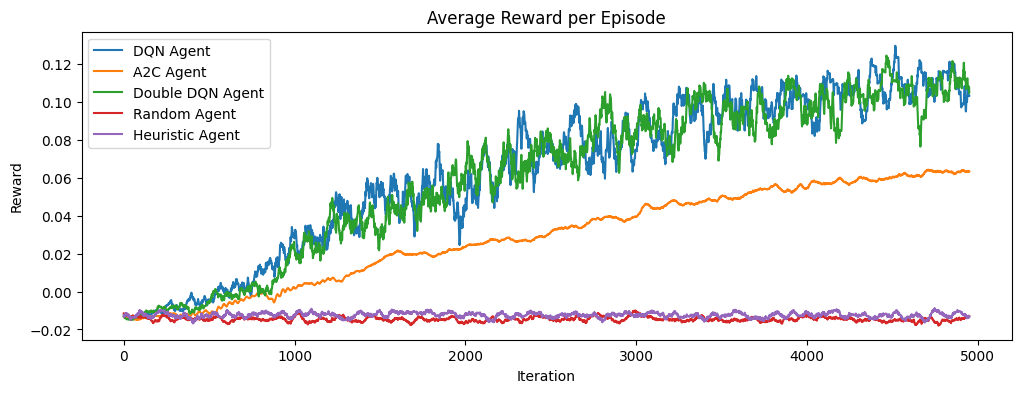

In [29]:
window = 50  # Adjust window size for more/less smoothing

def moving_average(data, window):
    return np.convolve(data, np.ones(window)/window, mode='valid')

plt.figure(figsize=(12, 4))

plt.plot(moving_average(rewards_history, window), label='DQN Agent')
plt.plot(moving_average(rewards_history_ac, window), label='A2C Agent')
plt.plot(moving_average(rewards_history_ddqn, window), label='Double DQN Agent')
plt.plot(moving_average(random_rewards, window), label='Random Agent')
plt.plot(moving_average(heuristic_rewards, window), label='Heuristic Agent')
plt.title('Average Reward per Episode')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.legend()
plt.savefig("plots/rewards.png", bbox_inches='tight')
plt.show()
plt.close()

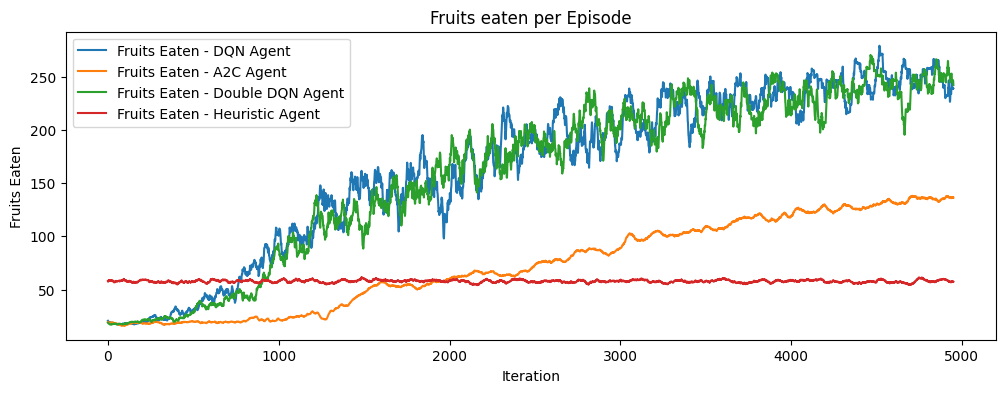

In [30]:
# Plot the fruits eaten
plt.figure(figsize=(12, 4))
plt.plot(moving_average(fruits_eaten_, window), label='Fruits Eaten - DQN Agent')
plt.plot(moving_average(fruits_eaten_ac, window), label='Fruits Eaten - A2C Agent')
plt.plot(moving_average(fruits_eaten_ddqn, window), label='Fruits Eaten - Double DQN Agent')
plt.plot(moving_average(fruits_eaten_heuristic, window), label='Fruits Eaten - Heuristic Agent')
plt.title('Fruits eaten per Episode')
plt.xlabel('Iteration')
plt.ylabel('Fruits Eaten')
plt.legend()
plt.savefig("plots/fruits_eaten.png", bbox_inches='tight')
plt.show()
plt.close()

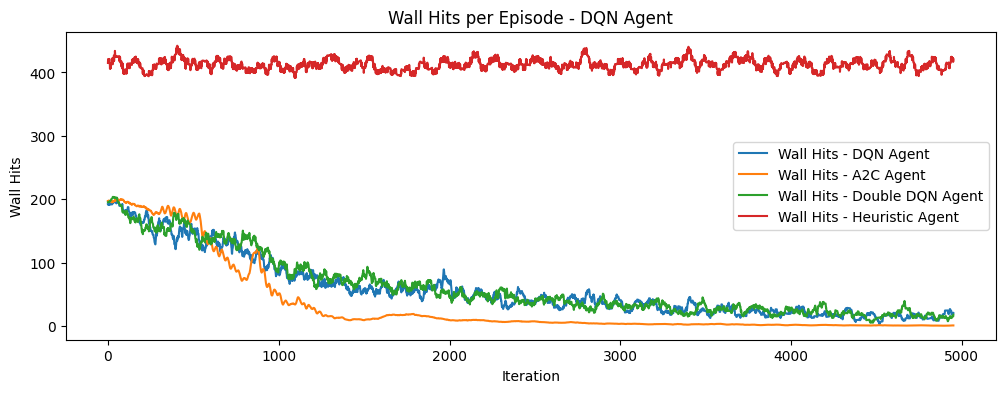

In [31]:
plt.figure(figsize=(12, 4))
plt.plot(moving_average(wall_hits, window), label='Wall Hits - DQN Agent')
plt.plot(moving_average(wall_hits_ac, window), label='Wall Hits - A2C Agent')
plt.plot(moving_average(wall_hits_ddqn, window), label='Wall Hits - Double DQN Agent')
plt.plot(moving_average(wall_hits_heuristic, window), label='Wall Hits - Heuristic Agent')
plt.title('Wall Hits per Episode - DQN Agent')
plt.xlabel('Iteration')
plt.ylabel('Wall Hits')
plt.legend()
plt.savefig("plots/wall_hits.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()